Fitting 5 folds for each of 48 candidates, totalling 240 fits

--- Best Parameters from GridSearchCV ---
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

--- Cross-Validation Results ---
CV Accuracy Scores: [0.97435897 0.96336996 0.97069597 0.96336996 0.96703297]
Mean CV Accuracy: 0.9678
Standard Deviation: 0.0043

--- Final Evaluation on Unseen Test Data ---
Accuracy: 0.9883
Precision: 0.9922
Recall: 0.9769
F1 Score: 0.9845
ROC AUC Score: 0.9861
Confusion Matrix:
 [[211   1]
 [  3 127]]


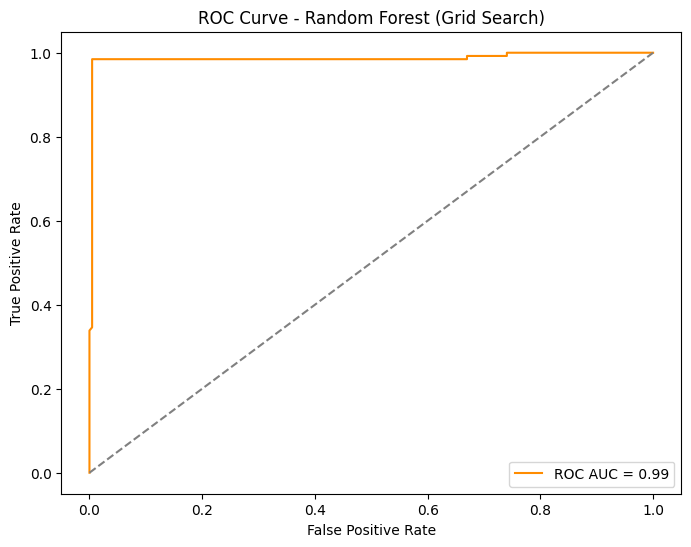

<ipython-input-7-d40e1e6027a5>:113: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10], palette='crest')


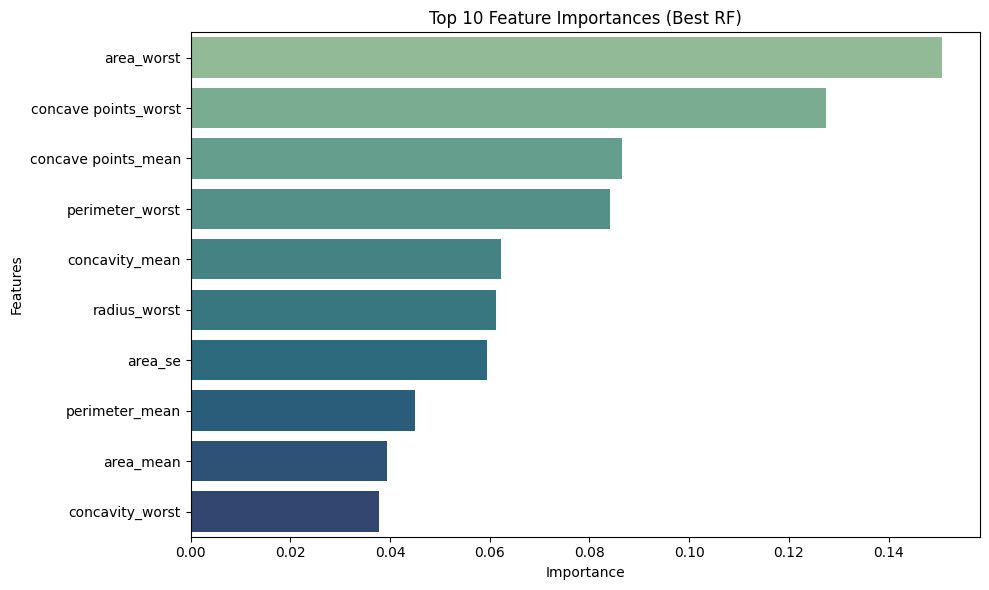

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# Load the Dataset
df = pd.read_csv('/content/Expanded_Dataset.csv')

# Drop unnecessary columns
df.drop(columns=['id', 'Unnamed: 32'], errors='ignore', inplace=True)

# Convert 'diagnosis' to binary (M=1, B=0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Split features and target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize base model
rf = RandomForestClassifier(random_state=42)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Best model from grid search
best_rf = grid_search.best_estimator_

print("\n--- Best Parameters from GridSearchCV ---")
print(grid_search.best_params_)

# Cross-validation scores with best estimator
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print("\n--- Cross-Validation Results ---")
print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train final model
best_rf.fit(X_train_scaled, y_train)

# Predictions
y_test_pred = best_rf.predict(X_test_scaled)
y_test_prob = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)

print("\n--- Final Evaluation on Unseen Test Data ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Grid Search)')
plt.legend()
plt.show()

# Feature Importance Plot
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values[:10], y=feature_importance.index[:10], palette='crest')
plt.title('Top 10 Feature Importances (Best RF)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
